## IMPORTING NECESSARY LIBRARIES

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Suppress warnings =
import warnings
warnings.filterwarnings("ignore")

# LOADING DATA

In [2]:
try:
    df = pd.read_csv('../data/heart.csv')
except FileNotFoundError:
    print("File not found")

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

## SPLITTING DATA

In [4]:
X = df.drop(columns=['target'])  
y = df['target'] 

# First, split into training (80%) and temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second, split the temporary set into validation (50%) and test (50%) sets (both 10% of the total data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## MODEL TRAINING

In [5]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Evaluate performance (e.g., accuracy)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.9901960784313726


In [7]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9805825242718447


In [8]:
# Perform cross-validation with 5 folds
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99390244 0.9695122  1.         0.98780488 0.95731707]
Mean cross-validation score: 0.9817073170731707


In [9]:
param_grid = {
    'n_estimators': [100, 200, 50],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

In [10]:
# Use 10-fold cross-validation for more reliable estimates
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=cv, 
    scoring=scoring,
    refit='f1',  # Optimize for F1 score
    verbose=1,
    n_jobs=-1   
)

In [11]:
# Perform grid search on the training set
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits

Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.9963409185841673


In [12]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

In [13]:
# Validate the best model on the validation set
y_val_pred_best = best_model.predict(X_val)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"Validation Accuracy with Best Model: {val_accuracy_best}")

Validation Accuracy with Best Model: 0.9901960784313726


In [14]:
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        50

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



## FEATURE IMPORTANCE

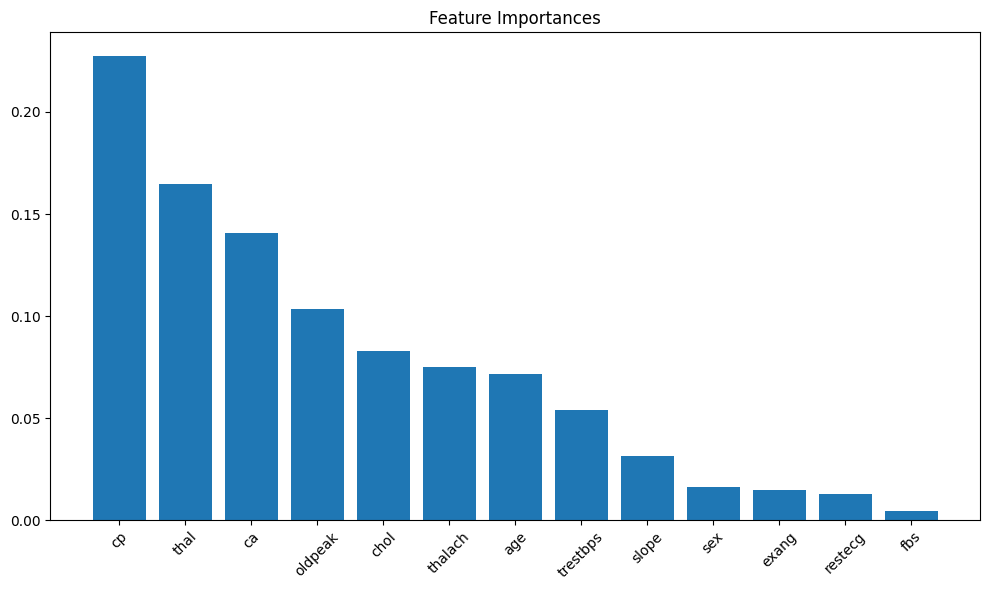

In [15]:
feature_names = X_train.columns
feature_importances = best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances with actual feature names
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(min(20, len(indices))), feature_importances[indices][:20], align='center')
plt.xticks(range(min(20, len(indices))), feature_names[indices][:20], rotation=45)
plt.tight_layout()
plt.show()

## LEARNING CURVE TO CHECK OVERFTTING

In [16]:
# Use ShuffleSplit for repeated random sub-sampling
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)


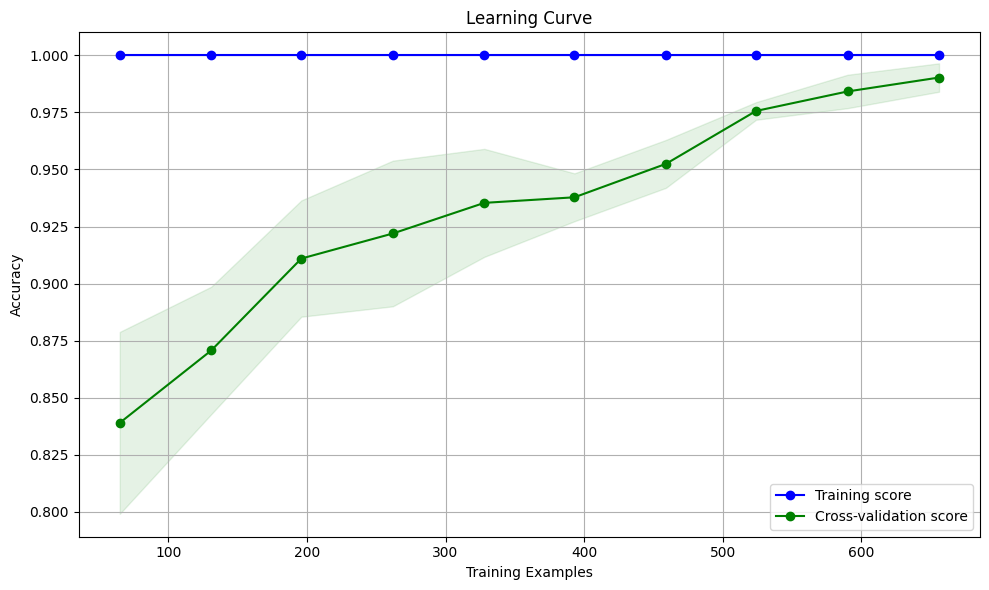

In [17]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# INSIGHT
The learning curve shows that as the number of training examples increases, both the training and cross-validation accuracy scores improve, indicating the model is learning effectively. 

Both training and validation scores improve with more data, suggesting the model is learning meaningful patterns rather than memorizing noise.

**Close Alignment of Scores:**
1. The validation accuracy (0.990) and test accuracy (0.981) are nearly identical, indicating strong generalization to unseen data.

2. The mean cross-validation score (0.982) is also consistent, with minimal variance across folds (range: 0.957–1.0).

## SAVING MODEL

In [25]:
import joblib
import os
from pathlib import Path  

MODELS_DIR = Path('../models')
MODEL_PATH = MODELS_DIR / 'heart_disease_predictor.pkl'

MODELS_DIR.mkdir(parents=True, exist_ok=True)

try:
    joblib.dump(model, MODEL_PATH)
except Exception as e:
    print(f"Failed to save model: {str(e)}")
    raise


In [26]:
# load the model
try:
    loaded_model = joblib.load(MODEL_PATH)
except FileNotFoundError:
    print("Error: Model file not found. Train the model first.")
except Exception as e:
    print(f"Error loading model: {str(e)}")

## EXAMPLE

In [27]:
input_data = {
    'age': 55,
    'sex': 1,          # 1 = male, 0 = female
    'cp': 2,           # Chest pain type (0-3)
    'trestbps': 130,   # Resting blood pressure
    'chol': 250,       # Cholesterol
    'fbs': 0,          # Fasting blood sugar (0 or 1)
    'restecg': 1,      # Resting ECG results (0-2)
    'thalach': 150,    # Max heart rate
    'exang': 0,        # Exercise-induced angina (0 or 1)
    'oldpeak': 1.2,    # ST depression induced by exercise
    'slope': 2,        # Slope of peak exercise ST segment
    'ca': 1,           # Number of major vessels (0-3)
    'thal': 2          # Thalassemia type (1-3)
}


input_df = pd.DataFrame([input_data])  # Single row DataFrame

In [28]:
prediction = model.predict(input_df)  # Returns class (0 or 1)
probabilities = model.predict_proba(input_df)  # Probability scores [P(0), P(1)]

print(f"Predicted class: {prediction[0]}")
print(f"Probability of heart disease: {probabilities[0][1]:.2%}")

Predicted class: 1
Probability of heart disease: 83.00%
